## DSAN 5650 HW2A: Linear Regression with Stan (Modeling Languages I)

**Assignment Corrections (Run Following Cell to Fetch)**

In [ ]:
jagr::fetchCorrections("2025-sum-dsan5650", "HW2A")

**DSAN5650 HW2A Corrections**

None so far!


*Last fetched: Sat Jun 21 23:42:07 2025 EDT*

**Assignment Submission (Run Following Cell to Generate Submit Button)**

In [ ]:
# Coming Soon...

### Overview

At the beginning of the [Week 4](https://jjacobs.me/dsan5650/w04/slides.html#/title-slide) lecture, we talked about why it might be worthwhile -- as data scientists in general but especially as *social* scientists -- to take the time to learn a full-on **language** for probabilistic modeling, as opposed to continuing down the path of learning individual models one-by-one and adding them to our "toolbox".

In the same way that becoming fluent in a language allows you to **adapt** to novel circumstances (in the "One hamburger please" example from the slides, for example, having only that phrase would leave you helpless if the cashier reported back "Sorry, hamburger machine broke, but we can make you a [hotdurger](https://rocketpower.fandom.com/wiki/Hotdurger) if you'd like"), becoming fluent in a **modeling language** like PGMs allows you to adapt "off-the-shelf" models like linear regression or SVMs to the particularities of your data analysis project!

### Two Goals

The **first** goal for this homework is therefore to make good on all this, by walking you through a social-scientific project where the full richness of this modeling language is necessary if we actually want to capture the thing we'd like to **learn about the social world**. **Part 1** below provides a gentle introduction by walking you through the process of converting the `lm()`-based approach to regression (which is *not* expressed in a full-on modeling language like Stan, but is carried out via "templated" function calls) into PGM language in the form of Stan code.

**Part 2** then begins your journey into using Stan to infer relationships between variables from real (non-simulated) data, the **Afrobarometer** data discussed in class, with the relevant details provided at the beginning of that section. **Part 3**, which will be the only part in **HW2B**, will then cap off this journey by having you work out a full-on multilevel model which **pools** information across different countries in a statistically-principled manner.

Then, whereas that first goal (the goal underlying Parts 1-3) relates to **applying** the pieces of the language that we already know, the **second** goal for this homework (underlying **Parts 4-5**, which will be combined into **HW2C**) is to **extend** our vocabulary with respect to this language, by adding in new terms and new grammatical constructions. But, rather than tucking these details away into HW2C, I want to **prime** you to start thinking about them now, right at the beginning!

First, for talking about the **causal impacts** of certain variables on others, as discussed ad nauseum in lecture thus far, we'll need to add the **$\textsf{do}()$ operator**, which will be the focus of **Part 4**. Concretely: In this language we already know...

* How to represent a **Random Variable** like $X$ (as a node in the PGM), and
* How to "encode" **Conditional Probabilities** like $\Pr(Y \mid X)$ (as an arrow from the $X$ node to the $Y$ node, with an associated Conditional Probability Table)

It turns out that the $\textsf{do}()$ operator is not a "thing" inside of our PGM (like a circle or an arrow), but a different type of animal entirely. It is a **transformation** that we can **apply** to a given PGM, which then alters the PGM's semantic interpretation as "how these variables are related **after** an **active intervention** to force one of the variables to have a particular value". There is a table in Part 4 which will give the full details, but the distilled version is:

* With a PGM $\mathcal{M}$ in hand, $\Pr(Y \mid X = 5)$ tells us "Probability of $Y$ taking on some value after a **passive observation** that $X$ has the value 5", with respect to the relationships between variables (including $X$ and $Y$, but also any additional variables we think are relevant) specified by $\mathcal{M}$.
* $\Pr(Y \mid \textsf{do}(X = 5))$ tells us "Probability of $Y$ taking on some value after an **active intervention** to **force** $X$ to have the value 5", with respect to the relationships between variables in a **new** PGM $\mathcal{M}' = \mathcal{M}_{\textsf{do}(X = 5)}$, a **transformation** of $\mathcal{M}$ which can be **constructed algorithmically** from $\mathcal{M}$ to represent the **post-intervention** relationships between the variables we specified in $\mathcal{M}$.

### ...But, We Only Have Observational Data... 

After learning how $\textsf{do}()$ acts on our models in this way, you may suddenly become cynical and mad at me:

> "Wait a minute Jeff... this is nice in theory, but we're **data scientists**. We typically ***don't* have the ability to intervene** in some system $\textsf{do}$-style, we just get a `.csv` file and we're asked to analyze it after the fact!"

If that thought comes to your mind, don't worry: that means you're thinking about this in the exact right way! However, there is still (very much) hope!

In these (very common) cases, when we can't actually go out into the world and "do" the $\textsf{do}()$ operation, we can still do the following to **infer causality (asymptotically) from observational data** in light of our explicitly written-out PGM model $\mathcal{M}$:

1. First, compute the new PGM $\mathcal{M}'$ that results from **simulating** the effect that a $\textsf{do}()$ intervention has on some variable $X$ in $\mathcal{M}$ (again, given our modeling assumptions, which we've explicitly encoded into $\mathcal{M}$)
2. Next, compare $\mathcal{M}'$ to $\mathcal{M}$: Are there causal pathways between $X$ and $Y$ in $\mathcal{M}$ that no longer exist in $\mathcal{M}'$? Write those down, because, these are **precisely the "backdoor paths" you'll need to account for** if you want to obtain causal effects from $\mathcal{M}$, the model you *do* have observational data on, rather than $\mathcal{M}'$, the model you don't have data for (since that would require going out and re-generating the dataset after appropriate $\textsf{do}()$ interventions)
3. Decompose these pathways into **triples** of nodes, then use your knowledge of the **Four Elemental Confounds** to determine whether the pathway is **already closed** (contains a collider), or whether it **needs to be closed**, in which case you can close it by conditioning on the appropriate variable: either the middle of a *Fork* or *Chain* (to **fully** close the pathway), or a **proxy** for the middle of a *Fork* or *Chain* (to partially close it).

It is this using-a-causal-model-to-figure-out-corrections-to-our-observational-data that **Part 5** will walk you through. Yalla!

## [Part 1] Tutorial with Example Data: From `lm()` to Stan

An overarching goal in this first half of the course is to **convert** "memorized" statements ("regress $X$ on $Y$", "find a set of coherent clusters within the feature matrix $X$", etc.) into "phrases" which you can express as PGMs. So, as mentioned in Week 5, in Parts 1 and 2 we provide you with already-estimated regression models, and your job is to **rewrite** these `lm()`-based models into `quap()` or `ulam()`-based models. This part doesn't have any questions you need to complete -- it's here to quickly walk you through your first example of Stan code, which you can then build upon for Parts 1 and 2! 

[Sidebar: as briefly described in the `rethinking` documentation [here](https://github.com/rmcelreath/rethinking?tab=readme-ov-file#quadratic-approximation-with-quap), `quap()` is short for **quadratic approximation**, and provides a "lite", approximate version of the more computationally-intensive Markov Chain Monte Carlo (MCMC) estimation performed by `ulam()`. In Part 1.1 -- but not in Part 1.2! -- `quap()` should be able to successfully recover the same regression coefficients that `lm()` produces.]

### [Question 1.1] Example DGP $\rightarrow$ Best-Fit Line

To make the values here meaningful -- which will help us when choosing prior distributions below -- you can interpret values of $X_i$ as the **weight** of a given [sea otter](https://en.wikipedia.org/wiki/Sea_otter) in kg, and values of $Y_i$ as that sea otter's **length** in cm. The code in the `Q1.1-example-code` cell should look familiar to you from previous courses: we first generate $n = 100$ datapoints by way of the following **Data Generating Process (DGP)**:

$$
\begin{align*}
X_i &\sim \mathcal{U}[10, 50] \\
Y_i &\sim \mathcal{N}\left(5 + 1.5 X_i, 9\right)
\end{align*}
$$



That $Y \sim \mathcal{N}(5 + 1.5 X, 9)$ line contains a bunch of important info squished together. It corresponds to a (noisy) linear relationship between $X$ and $Y$ that is more commonly written in regression settings as:

$$
Y = 5 + 1.5 X + \varepsilon,
$$

where $\varepsilon$ is a zero-mean normally-distributed error term (in this case, specifically, we know $\varepsilon \sim \mathcal{N}(0, 9)$), $\beta_0 = 5$ is our intercept, and $\beta_1 = 1.5$ is our slope.

If we apply a method like Ordinary Least Squares to the generated data, we can derive **estimates** $\widehat{\beta}_0$ and $\widehat{\beta}_1$ of the $\beta_0$ and $\beta_1$ coefficients in $Y = \beta_0 + \beta_1 \cdot X$, by providing this method with a dataset like the $n = 100$ dataset we generate here. The **OLS-estimated** line derived from these $n = 100$ points,

$$
\widehat{y} = \widehat{\beta}_0 + \widehat{\beta}_1 x,
$$

then gives us the function which **best predicts values of $y$ from given values of $x$**. At one more level of detail<sup>[1]</sup>, it is a "best" linear interpolation (with respect to Mean Squared Error) of the collection of data points $\mathbf{d} = \left(x,~\mathbb{E}[Y \mid X = x]\right)_{x,y \in (X,Y)}$.

Run the following code cell to see the generated data and estimated linear regression model, then answer the questions given immediately after the code cell:

---

<small>1. You can dig even deeper into why the $\mathbb{E}[Y \mid X = x]$ is an important detail by reading Chapter 1 of [*Advanced Data Analysis from an Elementary Point of View*](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/) by Cosma Shalizi!</small>

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::map()    masks rethinking::map()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Call:
lm(formula = y ~ x, data = example_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-25.9660  -7.0187   0.2393   6.1838  29.2610 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.86247    2.81084   2.086   0.0396 *  
x            1.49027    0.08879  16.784   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.803 on 98 degrees of freedom
Multiple R-squared:  0.7419,	Adjusted R-squared:  0.7393 
F-statistic: 281.7 on 1 and 98 DF,  p-value: < 2.2e-16


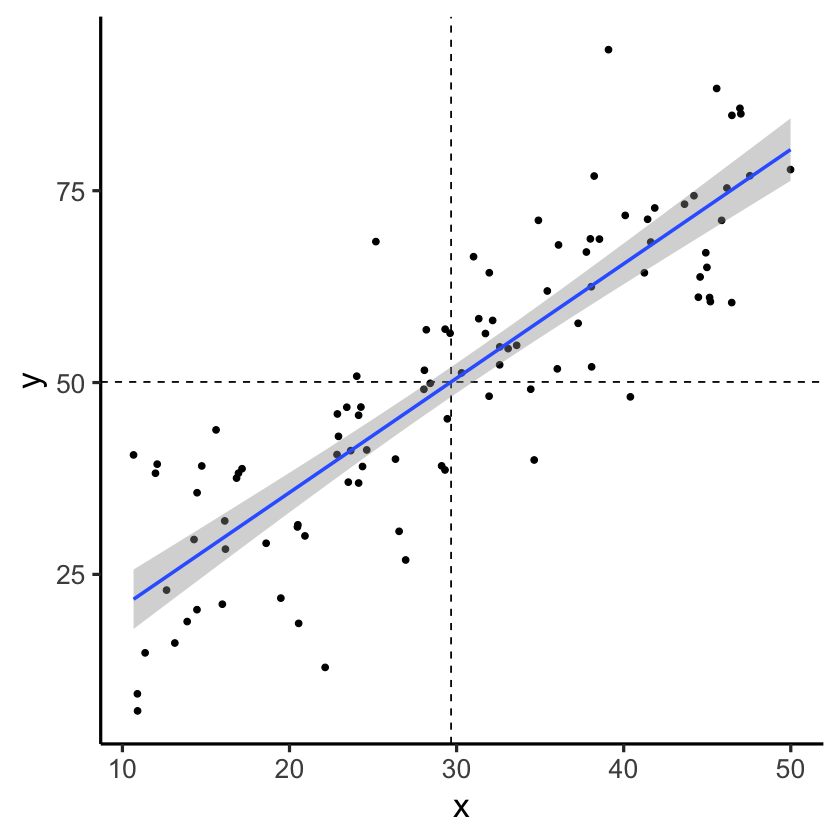

In [2]:
# @title Q1.1-example-code
library(tidyverse)

# Generate random data
set.seed(5650)
n <- 100
x_vals <- runif(n, 10, 50)
y_noise <- rnorm(n, 0, 9)
y_vals <- 5 + 1.5 * x_vals + y_noise
example_df <- tibble(x=x_vals, y=y_vals)

# Visualize the regression line
example_df |> ggplot(aes(x=x, y=y)) +
  geom_point() +
  # Draw x and y means as dashed lines
  geom_vline(xintercept=mean(example_df$x), linetype="dashed") +
  geom_hline(yintercept=mean(example_df$y), linetype="dashed") +
  geom_smooth(method='lm', formula='y ~ x') +
  theme_classic(base_size=20)

# Regression line coefficients, estimated via simple lm() model
example_lm <- lm(y ~ x, data=example_df)
summary(example_lm)

**Question 1.1a**

Complete the following code cell by computing `b0_err_lm` and `b1_err_lm`, representing how far off (in terms of absolute value) the coefficient estimates in `example_lm` are from the **true values**, which we know in this case since we generated the data ourselves in `Q1.1-example-code`. (We'll compare these values with the errors from the Stan model later on)

In [ ]:
# @title Q1.1a-response

b0_err_lm <- abs(coef(example_lm)[1] - 5)  # Your code here (replace the NULL)
b1_err_lm <- abs(coef(example_lm)[2] - 1.5) # Your code here (replace the NULL)

writeLines(paste0("beta0 absolute error: ",b0_err_lm))
writeLines(paste0("beta1 absolute error: ",b1_err_lm))

beta0 absolute error: 0.862472137643008
beta1 absolute error: 0.0097284184261972


**Question 1.1b**

Select the appropriate completion of the sentence: Using `lm()` to estimate a regression provides us with...

* (a) A full **probability distribution** over possible regression lines (that is, a distribution over possible values of the intercept $\beta_0$ and the slope $\beta_1$)
* (b) Just a **point estimate** of the regression line intercept $\beta_0$ and slope $\beta_1$ (along with their standard errors)

In [ ]:
# @title Q1.1b-response
q1_1b_response <- "b" # Replace with "a" or "b"

### [Question 1.2] Writing the DGP in an Explicit Generative Form

Now, like I've ranted about in class, this use of `lm()` is all well and good if we only ever want to estimate linear regressions and never want to adapt/modify this base model to handle the particularities of our modeling scenario! But, if we want to be able to "express" -- to "talk about" -- this regression in the general modeling **language of PGMs**, we'll need to use a probabilistic language like **WebPPL** that you saw in HW1, or **Stan** which you'll see in this homework!

To recast linear regression into Stan, the key step for us is to focus in on the "language" which you actually saw just above, when we wrote out our **DGP** as:

$$
\begin{align*}
X &\sim \mathcal{U}[10, 50] \\
Y &\sim \mathcal{N}(5 + 1.5 X, 9)
\end{align*}
$$

In fact, when I write out models that I'd like to implement in Stan, I usually use the format that's used in *Statistical Rethinking*, where there's an additional "comment column" on the right side of each line, describing what's going on: 

<table>
<thead>
<tr>
    <th colspan="5">The True Data Generating Process</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$X$</td>
    <td>$\sim$</td>
    <td>$\mathcal{U}[10, 50]$</td>
    <td><small>Generate $X$ uniformly in $[10, 50]$</small></td>
</tr>
<tr>
    <td>2.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(5 + 1.5 X, 9)$</td>
    <td><small>Draw $Y$ from a normal distribution centered at $5 + 1.5 X$ with variance $9$</small></td>
</tr>
</tbody>
</table>

This two-step generative algorithm is the **true** DGP, which we have here since we're using simulated data generated per our explicit instructions (in the form of R code), but which we usually do **not** have -- for example, we don't know the "true" pathway by which an individual's views on authority combine with their political party and country of residence to produce their views on China.

So, instead, we need to use a model like linear regression to try and **recover** the relationship between $X$ and $Y$ as best as we can given the data available to us. And, it turns out that we can actually write our **model** for recovering the parameters of a regression like $\beta_0$ and $\beta_1$ in the **exact same language** that we wrote our DGP in!<sup>[1]</sup> In the following steps, we'll build up the linear regression model in this explicitly-written-out generative form.

---

<small>

1.  This ability, the fact that we can write **both** (a) our hypothesized DGP for $X$ and $Y$ **and** (b) our model for recovering **estimates** of the relationship between $X$ and $Y$ (like the regression estimates $\widehat{\beta}_0$ and $\widehat{\beta}_1$), turns out to be a **huge huge humongous important key feature** of this Bayesian PGM language! The hugeness and importance will come into play a bit later in the course, but for now you can think about how **missing data** is typically handled by `lm()` (where a row containing a single missing value gets thrown out, even if other values in the row are non-missing), and how an explicit, generative model like this could allow you **squeeze more statistical power** out of your data.

    As a hint, think of the multilevel Radon example from Week 5: if we specify the degree of **adaptive pooling** we'd like our model to perform across units within a cluster (say, with one cluster of counties in the Eastern half of Minnesota and the other containing counties in the Western half), we can then optimally *infer* estimates for missing values from other units in the same cluster: For example, if the mean temperature of one house in the Western half of Minnesota is missing, we don't have to throw this entire house away! Stan can automatically infer a posterior distribution for this house's temperature from the joint distribution of non-missing temperatures with other attributes of houses in that half of Minnesota 

</small>

**Question 1.2 (Multiple Select)**

*(Your first example of how modeling languages allow us to adapt to different modeling circumstances!)*

Here, let's say that we're interested in expanding our model so that it can generate **male** and **female** otters with [slightly different characteristics](https://www.montereybayaquarium.org/animals/animals-a-to-z/sea-otter). The process we'd like to use, in words, is as follows:

1.  First, "nature" flips a fair coin to determine the otter's sex $S$: $S = 1$ for **female** if the coin comes up **Heads**, and $S = 0$ for **male** otherwise.
2.  Now, rather than generating otter weights $X$ uniformly in $[10,50]$, the bounds of the uniform distribution **depend** on $S$:
    * If $S = 1$, $X$ should be generated uniformly in $[10, 40]$.
    * Otherwise, if $S = 0$, $X$ should be generated uniformly in $[20, 50]$
3.  The determination of otter **lengths** proceeds as before: drawn from a normal distribution centered at $5 + 1.5X$ with variance $9$.

Which of the following new DGPs would successfully implement these three steps? "Check" all that apply in the `Q1.2-response` code cell, by setting the variable to the value `TRUE` for a "check" and `FALSE` for no check.

<table>
<thead>
<tr>
    <th colspan="5" align="center">DGP (a)</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$S$</td>
    <td>$\sim$</td>
    <td>$\text{Bern}(p = 0.5)$</td>
    <td><small>Generate $S$ as the result of a fair coin flip ($p = 0.5$).</small></td>
</tr>
<tr>
    <td>2.</td>
    <td>$X$</td>
    <td>$\sim$</td>
    <td>$\mathcal{U}[10, 50]$</td>
    <td><small>Generate $X$ uniformly in $[10, 50]$</small></td>
</tr>
<tr>
    <td>3.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(5 + 1.5 X, 9)$</td>
    <td><small>Draw $Y$ from a normal distribution centered at $5 + 1.5 X$ with variance $9$</small></td>
</tr>
</tbody>
</table>

<table>
<thead>
<tr>
    <th colspan="5" align="center">DGP (b)</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$S$</td>
    <td>$\sim$</td>
    <td>$\text{Bern}(p = 0.5)$</td>
    <td><small>Generate $S$ as the result of a fair coin flip ($p = 0.5$).</small></td>
</tr>
<tr>
    <td>2.</td>
    <td>$X$</td>
    <td>$\sim$</td>
    <td>$\mathcal{U}[20 - 10S, 50 - 10S]$</td>
    <td><small>Generate $X$ uniformly in $[20 - 10S, 50 - 10S]$</small></td>
</tr>
<tr>
    <td>3.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(5 + 1.5 X, 9)$</td>
    <td><small>Draw $Y$ from a normal distribution centered at $5 + 1.5 X$ with variance $9$</small></td>
</tr>
</tbody>
</table>

<table>
<thead>
<tr>
    <th colspan="5" align="center">DGP (c)</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$S$</td>
    <td>$\sim$</td>
    <td>$\text{Bern}(p = 0.5)$</td>
    <td><small>Generate $S$ as the result of a fair coin flip ($p = 0.5$).</small></td>
</tr>
<tr>
    <td>2.</td>
    <td>$a$</td>
    <td>$\leftarrow$</td>
    <td>$20 - 10S$</td>
    <td><small>Compute $a$ as the result of $20 - 10S$ (i.e., $a$'s value is determined once $S$ is generated)</small></td>
</tr>
<tr>
    <td>3.</td>
    <td>$b$</td>
    <td>$\leftarrow$</td>
    <td>$50 - 10S$</td>
    <td><small>Compute $b$ as the result of $50 - 10S$ (i.e., $b$'s value is determined once $S$ is generated)</small></td>
</tr>
<tr>
    <td>4.</td>
    <td>$X$</td>
    <td>$\sim$</td>
    <td>$\mathcal{U}[a, b]$</td>
    <td><small>Generate $X$ uniformly in $[a, b]$</small></td>
</tr>
<tr>
    <td>5.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(5 + 1.5 X, 9)$</td>
    <td><small>Draw $Y$ from a normal distribution centered at $5 + 1.5 X$ with variance $9$</small></td>
</tr>
</tbody>
</table>

In [ ]:
# @title Q1.2-response
q1_2_a <- FALSE # Change to TRUE to "check" DGP (a)
q1_2_b <- TRUE # Change to TRUE to "check" DGP (b)
q1_2_c <- TRUE # Change to TRUE to "check" DGP (c)

### [Question 1.3] Writing Linear Regression in an Explicit Generative Form

First, note the above detail about how linear regression is simply interpolating a "best fit" line between the values of $\mathbb{E}[Y \mid X = x]$, values which can be computed using the $x_i$ datapoints we have in our dataset. This is a nice (almost) **distribution-agnostic** feature of regression, since $\mathbb{E}[Y \mid X = x]$ essentially just means "the middle point of the distribution of values $Y$ takes on when $X$ has the value $x$".

I say "almost" distribution-agnostic because, there *are* distributions like the [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) for which $\mathbb{E}[Y]$ would be undefined. However, if we're willing to make the two basic assumptions that the distributions of $[Y \mid X = x]$ will have a **finite mean** and **finite variance**... then it turns out that these are precisely the two epistemological assumptions which are uniquely encoded in the **Normal distribution!** So, for this reason, we start our generative-form linear regression model with the following "first" step<sup>[1]</sup>:

<table>
<thead>
<tr>
    <th colspan="5">Linear Regression as a Generative Model</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(\mu_y, \sigma_y^2)$</td>
    <td><small>Draw $Y$ from a normal distribution with mean $\mu_y$ and variance $\sigma^2_y$</small></td>
</tr>
</tbody>
</table>

So, this says that we're modeling the values of $Y$, within "vertical slices" of the data where $X = x$, as a

* Normal distribution,
* Centered at $\mu_y$,
* With a "width" of $\sigma_y^2$

The "width" $\sigma_y^2$ just represents how widely these values of $Y$ will vary around the center of the normal distribution in our model. But What is this $\mu_y$? That's exactly the **center point** of the range of $Y$ values we're modeling within the vertical slice $X = x$, namely, the **expected value** $\mathbb{E}[Y \mid X = x]$ we talked about above!

So, since the goal of regression is to fit a line as best as possible to the **centers** of these $x$-value-specific distributions of $Y$, as in the following figure:

<center>
<figure>
    <img src="https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/regression_normal_dist.jpg?raw=true" width="50%"></img>
    <figcaption><i>From <a href='https://jjacobs.me/dsan5300-01/w02/slides.html#/where-did-that-mathbbey-mid-x-x_i-come-from'>this DSAN 5300 slide</a></i></figcaption>
</figure>
</center>

It is precisely these normal-distribution means $\mu_y$ that we'll model as a line like $\mu_y = mx + b$, giving us the second line of our generative model:

<table>
<thead>
<tr>
    <th colspan="5">Linear Regression as a Generative Model</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(\mu_y, \sigma_y^2)$</td>
    <td><small>Draw $Y$ from a normal distribution with mean $\mu_y$ and variance $\sigma_y^2$</small></td>
</tr>
<tr>
    <td>2.</td>
    <td>$\mu_y$</td>
    <td>$\leftarrow$</td>
    <td>$\beta_0 + \beta_1 x$</td>
    <td><small>Compute $\mu_y$ from $x$ by plugging $x$ into the line equation $\mu_y = \beta_0 + \beta_1 x$</small></td>
</tr>
</tbody>
</table>

---

<small>

1.  Notice how, when we wrote out the **true** DGP earlier, we ordered the steps such that the first (generating $X$ values) had no dependencies, while the second (generating $Y$ values) depended on the first, since the $Y$ values are a function of the $X$ values. The ordering of steps in this part however, where we're trying to **recover** the values of model parameters **from** data, is the opposite: the first line here is the "end" of the PGM, and then we "work backwards" to the definition of $\mu_y$, then (in the next step) to the priors on $\beta_0$, $\beta_1$, and $\sigma^2_y$.

    Some people make a big deal out of this convention: that we should write **data-generation** PGMs from "beginning to end" (from priors to $X$ and $Y$ for example) and **parameter-estimation-from-data** PGMs from "end to beginning (from the generation of $X$ and $Y$ backwards to the priors that determine this generation). But, I put it in this footnote since I'm not sure how important it really is, except as a reminder that both data-generation and parameter-estimation-from-data tasks can both be written in the **same language**, which has important implications for e.g. handling **missing data** (see footnote in previous cell!)

</small>

**Question 1.3 (Multiple Select)**

Say we fixed the values $\beta_0 = 0$, $\beta_1 = 1$, and $x = 3$, then used the two-step generative model above to generate data in two ways:

* First, we set $\sigma^2_y$ to have the value $1$, then generate a dataset $\mathbf{d}^{(a)}$ with $n$ datapoints $\left\{\left(x^{(a)}_0, y^{(a)}_0\right), \ldots, \left(x^{(a)}_n, y^{(a)}_n\right)\right\}$
* Second, we set $\sigma^2_y$ to have the value $100$, then generate a dataset $\mathbf{d}^{(b)}$ with $n$ datapoints $\left\{\left(x^{(b)}_0, y^{(b)}_0\right), \ldots, \left(x^{(b)}_n, y^{(b)}_n\right)\right\}$

Which of the following statements about $\mathbf{d}^{(a)}$ and $\mathbf{d}^{(b)}$ do you think will be true? *("Check" all that apply, by setting the values in the `Q1.3a-response` cell to `TRUE`)*

* (a) The $x$ coordinates of points in $\mathbf{d}^{(a)}$ will take on a wider range of values than the $x$ coordinates of points in $\mathbf{d}^{(b)}$
* (b) The $x$ coordinates of points in $\mathbf{d}^{(b)}$ will take on a wider range of values than the $x$ coordinates of points in $\mathbf{d}^{(a)}$
* (c) The $y$ coordinates of points in $\mathbf{d}^{(a)}$ will take on a wider range of values than the $y$ coordinates of points in $\mathbf{d}^{(b)}$
* (d) The $y$ coordinates of points in $\mathbf{d}^{(b)}$ will take on a wider range of values than the $y$ coordinates of points in $\mathbf{d}^{(a)}$

In [ ]:
# @title Q1.3-response
q1_3_a <- FALSE # Change to TRUE to "check" option (a)
q1_3_b <- FALSE # Change to TRUE to "check" option (b)
q1_3_c <- FALSE # Change to TRUE to "check" option (c)
q1_3_d <- TRUE # Change to TRUE to "check" option (d)

### [Question 1.4] The Final Modeling Step: Priors! (On $\beta_0$, $\beta_1$, and $\sigma_y^2$)

This is... technically the spot where a lot of students get frustrated with PGMs (relative to the ease of using `lm()`), but I hope I've prepared you for this moment through my rants about how **Bayes' Rule** gives us a way to optimally update **prior hypotheses** on the basis of **new data** to derive new **posterior hypotheses**!

The fully-written-out linear regression PGM is shown in graphical form in the following diagram, which can give you a sense for how choosing values for the priors (the nodes pointing into $\beta_0$, $\beta_1$, and $\sigma^2_y$) is what "activates" the flow of information into the parameters, which in turn flow into the determination of $X$ and $Y$ via our generative model:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/20bd6795f50632a4508d3fcc4ed3aa9f393072a7/2025-sum-dsan5650/hw2/pgm_regression.svg" width="50%"></img>
<figcaption><i>The full PGM for our linear regression model, in graphical form. Notice how, since the priors like $\mu_0$, $\sigma^2_0$ don't have any arrows pointing into them, they are precisely where the "flow" of information starts: once priors have been set, inference can begin!</i></figcaption>
</figure>
</center>

In this case we can also retain some sanity by focusing in on our **estimation task**: rather than worrying about what priors "mean" in general, here we can just interpret them as our "initial guess" -- encoded as a **distribution over possible values** -- for $\beta_0$, $\beta_1$, and $\sigma_y^2$. So, we could come up with priors for our three parameters using **background knowledge** of otters as follows:

<table>
<thead>
<tr>
    <th>Parameter</th>
    <th>Example Background Knowledge</th>
    <th>Choice of Prior Distribution</th>
</tr>
</thead>
<tbody>
<tr>
    <td>$\sigma_y^2$</td>
    <td>Within a given (fixed) weight value $x$, otter lengths probably don't range by very much -- perhaps at most by $\pm$ 8 cm. So, I'll assume that (before I start observing data and "sharpening" this prior) values between 0 and 8 cm are equally likely (remember that variance = square of standard deviation!)</td>
    <td>$\sigma_y^2 \sim \mathcal{U}[0,64]$</td>
</tr>
<tr>
    <td rowspan="2">$\beta_1$</td>
    <td>(a) I'm not even going to assume that otters get longer as they get heavier; to match the open-endedness that the <code>lm()</code> function allows, I'm only going to assume that there's <i>some</i> amount $\beta_1$ by which an otter's height changes with its weight, and that this amount is within some reasonable bounds like $[-20, 20]$.</td>
    <td>$\beta_1 \sim \mathcal{U}[-20, 20]$</td>
</tr>
<tr>
    <td>(b) As an alternative to (a), rather than assuming equal likelihood for values between -20 and 20, I'll instead assume that the range is $(-\infty, \infty)$, but that the likelihood of a specific $\beta_1$ value <b>decreases as it gets further from 0</b>. For example, I'll assume that values like 3 or 5 are more likely than values like 10 billion, with the likelihood of a value $v$ dropping quadratically as $|v|$ increases.<br><br>Thus, I'll use the <b>Normal distribution</b>, to penalize values super far from 0 (since the Normal distribution implements a <b>quadratic</b> decrease in likelihood as values grow further from the mean, due to the $(x-\mu)^2$ term in the Normal PDF)</td>
    <td>$\beta_1 \sim \mathcal{N}(0, 10)$</td>
</tr>
<tr>
    <td rowspan="3">$\beta_0$</td>
    <td>(a) The <b>lightest</b> otters we've seen tend to be ~10kg and 20 $\pm$ 5cm long. The <b>heaviest</b> otters we've seen tend to be ~50kg and 80 $\pm$ 5cm long. Extrapolating this "trend" (between two points) back to a hypothetical weight of 0kg, we'd get an intercept of about 5 $\pm$ 5 cm. I'll use the Normal distribution like I did for $\beta_1$, to allow a range of values close to 5 but to penalize values which are super far from 5.</td>
    <td>$\beta_0 \sim \mathcal{N}(5, 2.5)$</td>
</tr>
<tr>
    <td>(b) Instead of the approach in (a), I'd instead like to ensure that $\beta_0$ takes on only non-negative values, since I know that otter heights don't go below 0! So, instead I'll use a uniform prior, starting my estimation with the assumption that the intercept could be any value from 0 to 20 with equal likelihood.<br><br><i></i></td>
    <td>$\beta_0 \sim \mathcal{U}[0,20]$</td>
</tr>
<tr>
    <td><i>(Optional fancy prior)</i> Note that we could <i>combine</i> both of the above pieces of information ((a) values-further-from-5-are-less-likely and (b) no-negative-values) via a fancy prior utilizing e.g. a lognormal or truncated-normal distribution! $\log(\beta_0) \sim \mathcal{N}(\log(5) + 1, 1)$, for example, would produce a prior with a mode of 5 and no negative values, and could be written in Stan below using <code>b0 ~ dlnorm(log(5)+1,1)</code>. For sanity, we stick to the first two options.</td>
    <td>$\log(\beta_0) \sim \mathcal{N}(\log(5)+\frac{1}{4}, \frac{1}{2})$</td>
</tr>
</tbody>
</table>

Once we've settled upon these prior distributions, our generative-format linear regression model is now complete! Picking the "more informative" choices from the above table for each parameter (though any of the choices above would work), we have:

<table>
<thead>
<tr>
    <th colspan="5">Linear Regression as a Generative Model</th>
</tr>
<tr>
    <th></th>
    <th colspan="3">Generative Step</th>
    <th>Comment</th>
</tr>
</thead>
<tbody>
<tr>
    <td>1.</td>
    <td>$Y$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(\mu_y, \sigma_y^2)$</td>
    <td><small>Draw $Y$ from a normal distribution with mean $\mu_y$ and variance $\sigma_y^2$</small></td>
</tr>
<tr>
    <td>2.</td>
    <td>$\mu_y$</td>
    <td>$\leftarrow$</td>
    <td>$\beta_0 + \beta_1 x$</td>
    <td><small>Compute $\mu_y$ from $x$ by plugging $x$ into the line equation $\mu_y = \beta_0 + \beta_1 x$<sup>[1]</sup></small></td>
</tr>
<tr>
    <td>3.</td>
    <td>$\sigma_y^2$</td>
    <td>$\sim$</td>
    <td>$\mathcal{U}[0,64]$</td>
    <td><small>Before observing data, values of $\sigma_y^2$ from 0 to 64 have equal likelihood</small></td>
</tr>
<tr>
    <td>4.</td>
    <td>$\beta_0$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(5, 2.5)$</td>
    <td><small>Most likely value for $\beta_0$ is 5; likelihood of other values $v$ decreases quadratically in $|v-5|$</small></td>
</tr>
<tr>
    <td>5.</td>
    <td>$\beta_1$</td>
    <td>$\sim$</td>
    <td>$\mathcal{N}(0, 10)$</td>
    <td><small>Most likely value for $\beta_0$ is 0; likelihood of other values $v$ decreases quadratically in $|v|$</small></td>
</tr>
</tbody>
</table>

Run the following code cell to see how this model is coded and estimated using **Stan**, by way of the `quap()` wrapper provided by the `rethinking` library (FYI: The use of `alist()`, as another "wrapper" around the lines of the generative model within the `quap()` wrapper, is **crucial** here -- `alist()` tells R "Hey, don't execute these lines right now! Keep them as symbolic expressions", since `quap()` will instead convert+plug them into Stan as parameter-estimate-generation instructions)

---

<small>

1.  Note how we use $\leftarrow$ rather than $\sim$ in the second line, because $\mu_y$ has no stochastic element: it is fully determined once we have values for $\beta_0$, $\beta_1$, and $x$! This mirrors the Stan code below, where the line defining `mu_y` is the only line which uses `<-` instead of `~`.

</small>

In [6]:
# @title Q1.4-example-code
library(rethinking)
x_mean <- mean(example_df$x)
example_pgm <- quap(alist(
    # 1. Generate y from mu_y, sigma2_y
    y ~ dnorm(mu_y, sigma2_y),
    # 2. Compute mu_y from b0, b1, x
    mu_y <- b0 + b1 * x,
    # 3. Prior on sigma2_y
    sigma2_y ~ dunif(0, 64),
    # 4. Choices for prior on b1
    # b1 ~ dunif(-20, 20),
    b1 ~ dnorm(0, 10),
    # 5. Choices for prior on b0
    b0 ~ dnorm(5, 2.5)
    #b0 ~ dunif(0, 20)
  ), data=example_df
)
(example_precis <- precis(example_pgm))

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
sigma2_y,9.705606,0.68637733,8.608643,10.802570
b1,1.504342,0.06302445,1.403617,1.605067
b0,5.386717,1.86000895,2.414063,8.359371


In the last line of the previous code cell, we summarize the model's estimates using `precis()`, which is just the `rethinking` library's version of the `summary()` function we use to see the results of an `lm()` model. Use this output to answer the following two questions:

**Question 1.4a**

Complete the following code cell by computing `b0_err_pgm` and `b1_err_pgm`, representing how far off (in terms of absolute value) the coefficient estimates in `example_pgm` are from the **true values**, which we know in this case since we generated the data ourselves in `Q1.1-example-code`.

In [ ]:
# @title Q1.4a-response

b0_err_pgm <- abs(coef(example_pgm)[3] - 5) # Your code here (replace the NULL)
b1_err_pgm <- abs(coef(example_pgm)[2] - 1.5) # Your code here (replace the NULL)

writeLines(paste0("beta0 absolute error: ",b0_err_pgm))
writeLines(paste0("beta1 absolute error: ",b1_err_pgm))

beta0 absolute error: 0.383856894274611
beta1 absolute error: 0.00442657880196884


**Question 1.4b**

Now, complete the following code cell, by computing the indicated differences between the `lm()` errors and the `quap()` errors:

In [ ]:
# @title Q1.4b-response
b0_diff <- b0_err_lm - b0_err_pgm # Your code here (replace the NULL)
b1_diff <- b1_err_lm - b1_err_pgm # Your code here (replace the NULL)

if (!is.null(b0_diff) & !is.null(b1_diff)) {
    b0_pct <- 100*((b0_diff/b0_err_lm))
    writeLines(paste0("b0: PGM estimates are ",round(b0_pct, 2),"% better"))
    b1_pct <- 100*((b1_diff/b1_err_lm))
    writeLines(paste0("b1: PGM estimates are ",round(b1_pct, 2),"% better"))
} else {
    writeLines("Specify values for b0_diff and b1_diff first!")
}

b0: PGM estimates are 55.49% better
b1: PGM estimates are 54.5% better


What your answers should indicate (from looking in the **mean** column) is that we've obtained estimates from `quap()` that are actually **closer** to the true values $\beta_0 = 5$ and $\beta_1 = 1.5$ than the estimates we obtained using `lm()` earlier . This is the beauty of informative priors:

* By incorporating even the most minimal background knowledge into our estimation, we can improve the veracity/precision of our estimates. And...
* If someone disagrees with the way we've incorporated this background knowledge into the model, they can **choose a different set of priors** and re-estimate the model to see if our claimed results still hold (or, better yet, we can **pre-emptively** choose different sets of priors and report the estimates for different settings accordingly -- this is called **robustness testing**)

### [Question 1.5] Plotting Posterior Estimates of the Regression Line

The remaining new thing, relative to `lm()`, is that our use of probabilistic priors means that we don't obtain a **single** regression line, but a **whole posterior distribution over regression lines**. This follows from the fact that we have:

* A whole posterior distribution over $\beta_0$ values, and
* A whole posterior distribution over $\beta_1$ values.

In both cases, the posterior distribution is derived via repeated, though computationally-optimized, applications of **Bayes Rule**: for example, in the $\beta_0$ case, taking our original prior distribution $\beta_0 \sim \mathcal{N}(5, 2.5)$ (which means that the prior PDF for $\beta_0$ is $f(x) = \varphi_{5, 2.5}(x)$<sup>[1]</sup>), and updating it in light of observed data $(x_i, y_i)$ to obtain a new distribution

$$
\underbrace{f(\beta_0 \mid (x_i, y_i))}_{\text{Posterior dist of }\beta_0} = \frac{f((x_i, y_i) \mid \beta_0)}{f((x_i, y_i))} \cdot \underbrace{f(\beta_0)}_{\text{Prior dist of }\beta_0}
$$

So yeah, this is a final fun fact about these explicitly-written-out generative PGMs: where in previous cases you may have computed the regression line first and then "added on" confidence bands around this line in an *ad hoc* manner, here we automatically derive not only "the" line, but actually an entire **probability distribution over lines**, the probability distribution which represents uncertainty about the relationship between $X$ and $Y$ after optimally ("optimally" in the sense of [De Finetti's Theorem](https://en.wikipedia.org/wiki/De_Finetti%27s_theorem) which I mentioned briefly in class) balancing the **observed data** with our **priors**.

What this means is, we can just draw a bunch of samples from the **posterior distribution** (the distribution we summarized above using `precis()`), using the `rethinking`-provided function `extract.samples()`, and then plot them with some transparency, so that the diagonal "bands" in the $x-y$ plane where the regression line is more likely end up looking darker than less-likely diagonal bands:

---

<small>

1.  Here $\varphi_{\mu, \sigma^2}(x)$ is the PDF of the Normal distribution with mean $\mu$ and variance $\sigma^2$

</small>

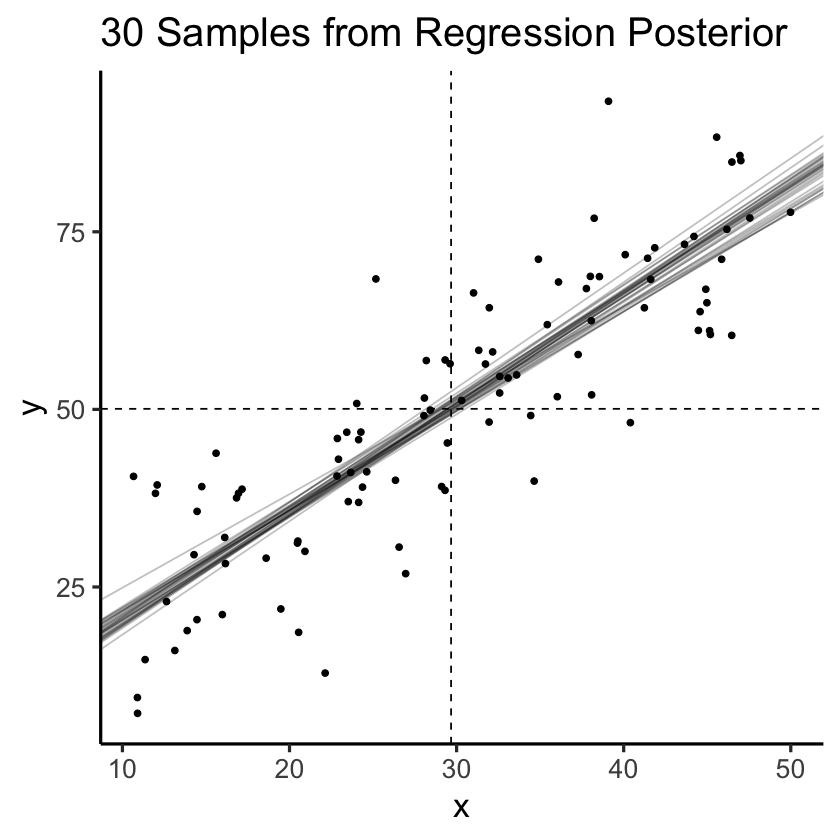

In [11]:
# @title Q1.6-example-code-1
set.seed(5650)
num_post_samples <- 30
example_post_df <- extract.samples(example_pgm, n=num_post_samples)
# example_post_df |> head()
ggplot() +
  geom_point(data=example_df, aes(x=x, y=y)) +
  geom_vline(xintercept=mean(example_df$x), linetype="dashed") +
  geom_hline(yintercept=mean(example_df$y), linetype="dashed") +
  geom_abline(
      data=example_post_df, aes(slope=b1, intercept=b0),
      alpha=0.25
  ) +
  theme_classic(base_size=20) +
  labs(title=paste0(num_post_samples, " Samples from Regression Posterior"))

Moreover, if we wanted (though this is sort of... falling prey to the classical regression framework, so some people tend to avoid it in Bayes world), there's an alternative to just drawing individual regression lines over and over again.

We could instead use the information contained in the estimated posterior distribution to derive what are called **compatibility intervals** (the Bayesian version of confidence intervals), like the **89% compatibility interval** produced by the following code cell.

Since we're literally "scooping out" the middle 89% of the posterior probability density function (PDF), this interval is kind of... the "real" version of the thing you **think** you're learning when you learn confidence intervals in high school stats classes! You can read through the first two examples in [this paper](https://www.colorado.edu/amath/sites/default/files/attached-files/2_23_2018.pdf) for details on the difference, but the short version is: **yes, unlike the case for frequentist confidence intervals, you *can* say (given standard Bayesian assumptions) that there's an 89% chance of the true regression line falling within this band!**

In [12]:
weight_vals <- seq(from=10, to=50, by=1)
mu_y <- link(example_pgm, data=data.frame(x=weight_vals))
mu_mean <- apply(mu_y, 2, mean)
mu_PI <- apply(mu_y, 2, PI, prob=0.89)

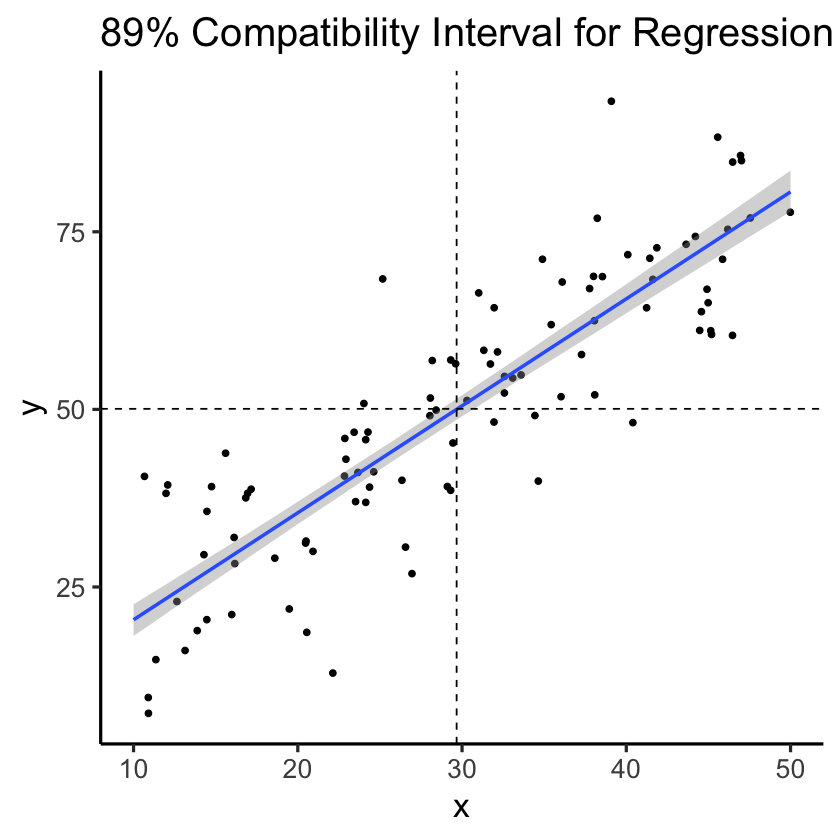

In [29]:
# @title Q1.6-example-code-2
# Derive 89% compatibility interval bounds
weight_vals <- seq(from=10, to=50, by=1)
mu_y <- link(example_pgm, data=data.frame(x=weight_vals))
mu_mean <- apply(mu_y, 2, mean)
mu_PI <- apply(mu_y, 2, PI, prob=0.89)
compat_df <- tibble(
    p5=mu_PI[1,],
    p94=mu_PI[2,],
    x=weight_vals,
    y=mu_mean
)
# And plot on top of scatter
ggplot() +
  geom_point(data=example_df, aes(x=x, y=y)) +
  geom_smooth(
      data=compat_df, aes(x=x, y=mu_mean, ymin=p5, ymax=p94),
      stat="identity"
  ) +
  geom_vline(xintercept=mean(example_df$x), linetype="dashed") +
  geom_hline(yintercept=mean(example_df$y), linetype="dashed") +
  theme_classic(base_size=20) +
  labs(title=paste0("89% Compatibility Interval for Regression"))

**Question 1.5a**

Under the assumptions of linear regression via `lm()`, if we plot a **95% confidence interval** around the estimated regression line (the default when plotting using `geom_smooth()` as we've done in the plots above), can we state that

> "There is a 95% probability that the true linear relationship between $X$ and $Y$ lies within this shaded area"?

* (a) Yes
* (b) No

In [ ]:
# @title Q1.5a-response
q1_5a_response <- "b" # Replace with "a" for Yes and "b" for No

**Question 1.5b**

Under the assumptions of linear regression via PGMs, if we plot an **89% compatibility interval** around the estimated regression line (as we did in the previous plot), can we state that

> "There is an 89% probability that the true linear relationship between $X$ and $Y$ lies within this shaded area"?

* (a) Yes
* (b) No

In [ ]:
# @title Q1.5b-response
q1_5b_response <- "a" # Replace with "a" for Yes and "b" for No

### [Question 1.6] Modeling *Centers* Rather Than *Intercepts*

As a final consideration before Part 1, there's one additional difference between the `lm()` and PGM approaches that we've "unlocked" now that we've converted the `lm()` approach into explicitly-written Stan code above!

Long story short, you're often making your life harder by trying to directly model the **$y$-intercept** of the regression line. For a bunch of (important) reasons, it's often much less brain-hurting to instead model the **value that $y$ takes on at the *mean* value of $x$**. For example:

* (a) you usually have more data on points near the mean than points out on the ends of the range of possible values, and
* (b) sometimes the range of valid $x$ values doesn't even include low values near $0$, which is exactly what you saw in the otter data above: the weight value $x$ never dips below 10, so our prior on $\beta_0$ had to awkwardly guess the value for a not-actually-possible value (the height of an otter weighing 0 kg)

So, the following code cell re-does the estimation from Parts 1.1-1.6, but models the regression line relative to the **mean** $x$ value: i.e., we parameterize the regression line as "starting" from some value `y_at_xmean`, our estimate of the value that $y$ takes on at the point $\mu_x = \frac{1}{n}\sum_{i=1}^{n}x_i$, then increasing (or decreasing) by `slope` for each 1-unit change in $x$ away from this mean value. It should only require a slight adjustment to switch back and forth between these forms, as can be seen from the following (new) PGM:

<center>
<figure>
<img src="https://raw.githubusercontent.com/jpowerj/dsan-content/f6c51e1f750f2a1173a150a57ba8f89a008b7c4e/2025-sum-dsan5650/hw2/pgm_regression_xmean.svg" width="40%"></img>
<figcaption><i>The new PGM for Question 1.6, where there are only two changes: (a) We model $\beta_0$ as the value of $y$ when $x$ is at its <b>mean</b> value $\mu_x$, rather than the value of $y$ when $x = 0$ (the intercept form); (b) We adjust our prior values on $\beta_0$ accordingly.</i></figcaption>
</figure>
</center>

This is the form you should use in Parts 1 and 2, since e.g. the independent variable `antiauth` that we start with is from 1 to 4 and thus never dips down to the value 0!

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
y_at_xmean,50.077826,0.96588363,48.534157,51.621494
slope,1.490156,0.08789377,1.349685,1.630628
sigma2_y,9.704209,0.68619120,8.607543,10.800875


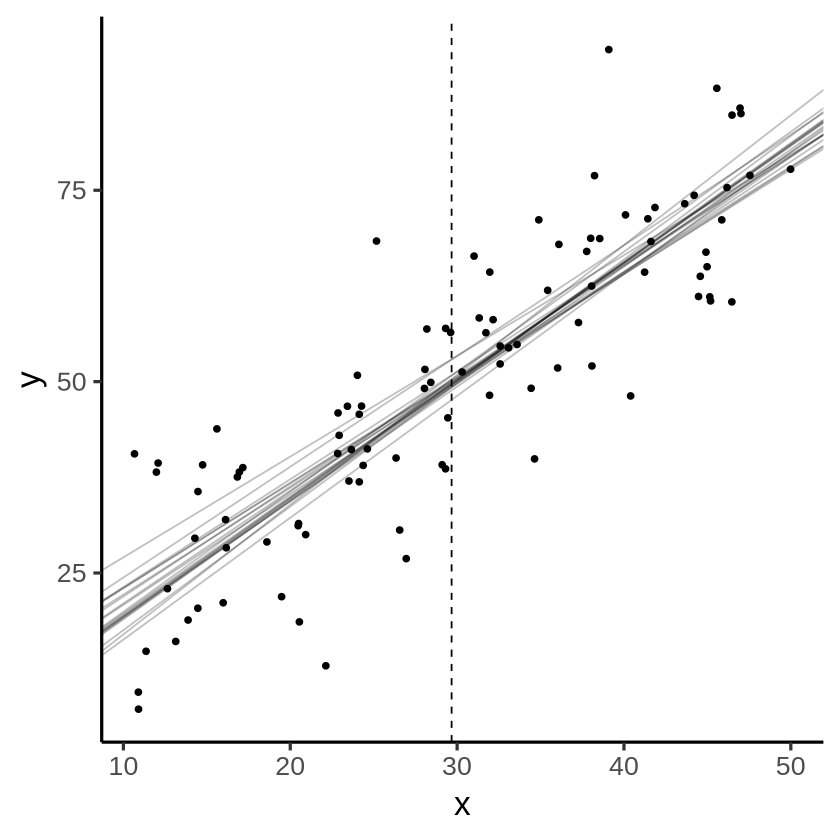

In [ ]:
# @title Q1.6-example-code
x_mean <- mean(example_df$x)
example_pgm <- quap(
  alist(
    y ~ dnorm(mu_y, sigma2_y),
    mu_y <- y_at_xmean + slope * (x - x_mean),
    y_at_xmean ~ dnorm(50, 10),
    slope ~ dnorm(0,10),
    sigma2_y ~ dunif(0,64)
  ),
  data=example_df
)
example_post_df <- extract.samples(example_pgm, n=20) |>
  mutate(intercept=y_at_xmean - slope * x_mean)
# example_post_df |> head()
ggplot() +
  geom_point(data=example_df, aes(x=x, y=y)) +
  geom_vline(xintercept=mean(example_df$x), linetype="dashed") +
  # geom_smooth(method='lm', formula='y ~ x') +
  geom_abline(
      data=example_post_df, aes(slope=slope, intercept=intercept),
      alpha=0.25
  ) +
  theme_classic(base_size=20)

Now that you've seen how to "convert" `lm()`-specific regression estimates into generalizable/modifiable models written out in Stan, the remainder of the assignment asks you to do this for each level of a multilevel regression separately, then combine them into a single all-encompassing multilevel model which **pools** data across clusters of observations!

**Question 1.6a**

Say we're working as a data analyst for a company that makes car engines. The company has some metric of engine performance $y$ with respect to the speed of the car $x$, and cares about modeling two aspects of an engine:

* The engine's "performance at rest", i.e., performance when the speed $x = 0$, and
* The engine's performance as speed increases, i.e., the change in performance $y$ for each unit increase in speed $x$ above 0

If the company wants you to start by estimating the linear relationship between speed and engine performance, which of the two PGM forms of regression should you opt for in this case?

* (a) The "standard" regression model, where we estimate $\beta_0$ as the $y$-intercept and $\beta_1$ as the slope (the change in engine performance for a 1-unit increase in speed)
* (b) The "centered" regression model, where we estimate $\beta_0$ as the value of $y$ when $x$ is at its mean, and $\beta_1$ as the slope (the change in engine performance for a 1-unit increase in speed)

In [ ]:
# @title Q1.6a-response
q1_6a_response <- "a" # Change to "a" for option (a), and "b" for option (b)

**Question 1.6b**

Now, say you're instead working for a credit card company, and they'd like you to model some "risk score" $y$ representing how likely a given individual is to default on a loan, given their FICO credit score $x$.

Given that FICO scores range from 300 to 850, which of the two PGM forms of regression should you opt for in this case?

* (a) The "standard" regression model, where we estimate $\beta_0$ as the $y$-intercept and $\beta_1$ as the slope (the change in risk per 1-unit increase in FICO score)
* (b) The "centered" regression model, where we estimate $\beta_0$ as the risk value $y$ when $x$ is at the mean FICO score in the dataset, and $\beta_1$ as the slope (the change in risk per 1-unit increase in FICO score)

In [ ]:
# @title Q1.6b-response
q1_6b_response <- "b" # Change to "a" for option (a), and "b" for option (b)

## [Part 2] Afrobarometer I: Single-Level Regressions in Stan

Introducing this part is greatly helped by the fact that we covered three key higher-level pieces of info in class during Week 5:

**Afrobarometer**

We briefly discussed the [Afrobarometer](https://www.afrobarometer.org/) survey dataset, in particular:

* How it has a cluster of questions (Q18 through Q19B) which assess **individual attitudes towards governmental authority**, forming our **individual-level independent variable** `antiauth`, and
* How it has another cluster of questions (Q78A through Q78B) which assess **individual attitudes towards the economic and political impact of China and the US on their home country**, forming our **individual-level dependent variable** `china`

**Social-Scientific Puzzles**

We then went through the social-scientific reasons why we might **not** be able to **explain** some social phenomenon -- in this case, the phenomenon of sentiment towards China among individuals across 39 countries in Africa -- using individual-level data on its own, or country-level data on its own.

Here, the challenge comes from the following four-country "puzzle" we discussed at the very beginning, where knowing only each individual's `antiauth` values would not allow you to explain the four different patterns exhibited by these four countries:

<figure>
<img src='https://github.com/jpowerj/dsan-content/blob/main/2025-sum-dsan5650/hw2/four-puzzles.png?raw=true' width='40%'></img>
<figcaption><i>The "four-country puzzle" exhibiting why we may need <b>country</b>-level data to explain <b>individual</b>-level attitudes towards China. On the off-diagonal, we have (a) positive sentiment regardless of `antiauth` level in Tanzania but (b) negative sentiment regardless of `antiauth` level in Tunisia. Then, on the diagonal, (c) sentiment increasing in `antiauth` level in Nigeria but (d) decreasing in `antiauth` level in Zimbabwe.</i></figcaption>
</figure>

**Historical/Sociological Background $\leadsto$ Hypotheses**

Finally, we covered some of the historical/sociological background for a few of the countries (Tanzania and Zimbabwe) which could be used to **generate hypotheses** about what might explain these social phenomena. In this case:

* China's early developmental aid to Tanzania in the 1970's...
* Juxtaposed to their military-political aid to Zimbabwe over roughly the same timespan...
* May lead us to a hypothesis that the **type** of aid given to the country matters for explaining our puzzle,
* Which in turn may lead us to go and operationalize this hypothesis, e.g., by disaggregating e.g. the `total_trade` variable into `total_development_aid` and `total_military_aid` components

So, now that I've justified my in-class rants as background-knowledge-provision, let's begin!

### [Question 2.1] Individual-Level Regression

Run the code cell immediately after this markdown cell, which loads the data, estimates the **individual**-level regression parameters, and generates a (binscatter) plot of the resulting linear model. This model relates changes in the independent variable $X =$ **anti-authoritarian attitudes** (`antiauth`) to changes in the dependent variable $Y =$ **sentiment towards China's role in the respondent's country** (`china`), with details as follows:

**Dependent Variable (Thing We're Trying to Explain): `china`**

* Question text: Do you think that the economic and political influence of **China** on **[your country]** is mostly positive, mostly negative, or haven't you heard enough to say?
* Values: 1=Very negative, 2=Somewhat negative, 3=Neither positive nor negative, 4=Somewhat positive, 5=Very positive

**Independent Variable (Thing We Hypothesize as Explanation for `china` values)**:

Here, the three variables averaged to produce the `antiauth` measure are structured as follows:

<table>
<thead>
<tr>
    <th align="center">QID</th>
    <th align="center">varname</th>
    <th colspan="2" align="center">Statement 1</th>
    <th colspan="2" align="center">Statement 2</th>
</tr>
</thead>
<tbody>
<tr>
    <td rowspan="3"><b>Q18</b></td>
    <td rowspan="3"><code>accountable</code></td>
    <td colspan="2">It is more important to have a government that can get things done, even if we have no influence over what it does.</td>
    <td colspan="2">It is more important for citizens to be able to hold government accountable, even if that means it makes decisions more slowly.</td>
</tr>
<tr>
    <td align="center">Strongly Agree</td>
    <td align="center">Agree</td>
    <td align="center">Agree</td>
    <td align="center">Strongly Agree</td>
</tr>
<tr>
    <td align="center">1</td>
    <td align="center">2</td>
    <td align="center">3</td>
    <td align="center">4</td>
</tr>
<tr>
    <td rowspan="3"><b>Q19A</b></td>
    <td rowspan="3"><code>gov_is_employee</code></td>
    <td colspan="2">The government is like the peoples boss. People should respect the government and do what it directs.</td>
    <td colspan="2">The government is like the peoples employee. It should respect the citizens and do what they request.</td>
</tr>
<tr>
    <td align="center">Strongly Agree</td>
    <td align="center">Agree</td>
    <td align="center">Agree</td>
    <td align="center">Strongly Agree</td>
</tr>
<tr>
    <td align="center">1</td>
    <td align="center">2</td>
    <td align="center">3</td>
    <td align="center">4</td>
</tr>
<tr>
    <td rowspan="3"><b>Q19B</b> (Reversed)</td>
    <td rowspan="3"><code>listen_to_voters</code></td>
    <td colspan="2">Our elected leaders should follow their own ideas in deciding what is best for the country.</td>
    <td colspan="2">Our elected officials should listen to voters' views and do what they demand.</td>
</tr>
<tr>
    <td align="center">Strongly Agree</td>
    <td align="center">Agree</td>
    <td align="center">Agree</td>
    <td align="center">Strongly Agree</td>
</tr>
<tr>
    <td align="center">1</td>
    <td align="center">2</td>
    <td align="center">3</td>
    <td align="center">4</td>
</tr>
</tbody>
</table>

In [34]:
ab_df <- read_csv("https://jpj.georgetown.domains/dsan5650-data/ab_multilevel.csv")
# Filter non-numeric (NA or DK) responses
valid_df <- ab_df |> filter(valid_china & valid_antiauth)

Rows: 53444 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): id, country_name, country_code, party_name, party_abbr, url, ideol...
dbl (12): china, usa, accountable, gov_is_employee, follow_own_ideas, party_...
lgl  (8): valid_china, valid_usa, valid_accountable, valid_employee, valid_l...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 53444 Columns: 29
 Column specification 
Delimiter: ","
chr  (9): id, country_name, country_code, party_name, party_abbr, url, ideol...
dbl (12): china, usa, accountable, gov_is_employee, follow_own_ideas, party_...
lgl  (8): valid_china, valid_usa, valid_accountable, valid_employee, valid_l...

 Use `spec()` to retrieve the full column specification for this data.
 Specify the column types or set `show_col_types = FALSE` to quiet this message.



Total number of countries (level 3): 38
Total number of political parties (level 2): 354
Total number of respondents (level 1): 40428



Call:
lm(formula = china ~ antiauth, data = valid_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6730 -1.4443  0.4794  1.4032  1.5557 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.749234   0.030638 122.371  < 2e-16 ***
antiauth    -0.076223   0.009751  -7.817 5.55e-15 ***
---
Signif. codes:  0 *** 0.001 ** 0.01 * 0.05 . 0.1   1

Residual standard error: 1.375 on 40426 degrees of freedom
Multiple R-squared:  0.001509,	Adjusted R-squared:  0.001484 
F-statistic:  61.1 on 1 and 40426 DF,  p-value: 5.549e-15


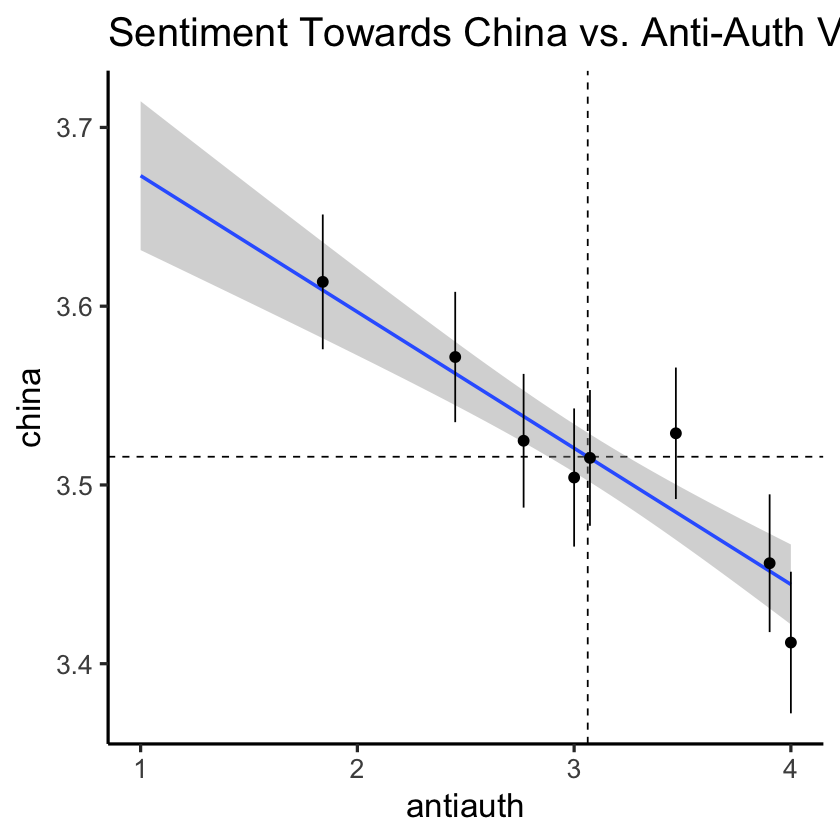

In [ ]:
# @title Q2.1-helper
library(tidyverse)
source("stat_binscatter.r")
# Load raw .csv data
ab_df <- read_csv("https://jpj.georgetown.domains/dsan5650-data/ab_multilevel.csv")
# Filter non-numeric (NA or DK) responses
valid_df <- ab_df |> filter(valid_china & valid_antiauth)

# Count number of observations at each level of the hierarchy
num_countries <- valid_df$country_name |> n_distinct()
writeLines(paste0("\nTotal number of countries (level 3): ",num_countries))
num_parties <- valid_df$party_vote |> n_distinct()
writeLines(paste0("Total number of political parties (level 2): ",num_parties))
n <- nrow(valid_df)
writeLines(paste0("Total number of respondents (level 1): ",n))

# Individual-level regression using lm()
indiv_lm <- lm(china ~ antiauth, data=valid_df)
summary(indiv_lm)

# And plot the regression line with (binscattered) points
ggplot() +
    geom_hline(yintercept=mean(valid_df$china), linetype="dashed") +
    geom_vline(xintercept=mean(valid_df$antiauth), linetype="dashed") +
    geom_smooth(
        data=valid_df, aes(x=antiauth, y=china),
        method="lm", formula="y ~ x"
    ) +
    stat_binscatter(
        data=valid_df,
        aes(x=antiauth, y=china),
        geom="pointrange", bins=8
    ) +
    theme_classic(base_size=20) +
    labs(title="Sentiment Towards China vs. Anti-Auth Values")

Your task now, in the cell titled `Q2.1a-response`, is to **convert this `lm()`-estimated regression into a `quap()`-estimated regression**, deriving the same (approximate) intercept and slope values!

In [ ]:
# @title Q2.1a-response
library(rethinking) |> suppressPackageStartupMessages()
aa_mean <- mean(valid_df$antiauth)
writeLines(paste0("Mean antiauth value: ",aa_mean))

indiv_model <- quap(
  alist(
    # Your code here (generative model for china as a function of antiauth)
    # 1. Generate y from mu_y, sigma_y
    china ~ dnorm(mu_antiauth, sigma_antiauth),
    # 2. Linear model definitino - Compute mu_y from b0, b1, x
    mu_antiauth <- b0 + b1 * antiauth,
    # 3. Prior distribution for sigma_y
    sigma_antiauth ~ dunif(0, 25),
    # 4. Prior distribution for b1
    b1 ~ dnorm(0, 1),
    # 5. Prior distribution for b0
    b0 ~ dnorm(3.5, 1)
  ),
  data=valid_df
)
precis(indiv_model)

Mean antiauth value: 3.06277002737376


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
sigma_antiauth,1.37465139,0.004834319,1.36692521,1.38237756
b1,-0.07614297,0.009746130,-0.09171916,-0.06056677
b0,3.74897849,0.030621689,3.70003911,3.79791786


Now, in the cell titled `Q2.1b-response`, first use the `extract.samples()` function from `rethinking` to draw **30 samples from the posterior regression line distribution**, i.e., 30 draws of the variables in `indiv_model`, and call this sample of 30 lines `post_df`.

Next, note how we're parameterizing the regression line as $\beta_{\bar{x}} + \beta_1 * (x - \overline{x})$. This means that there **won't** be a column in `post_df` corresponding to the `intercept` argument required by `geom_abline()`. To deal with this (since the `geom_abline()` function from `ggplot2` requires an `intercept` argument), compute a new column within `post_df` called `intercept` by using the `y_at_xmean` values and the `slope` values to extrapolate each line's $y$-intercept.

Finally, use `ggplot()` with the following layers (at minimum) to plot the results:

* Use `stat_binscatter()` with `bins=8` to plot the distribution of individual `antiauth` and `china` values in `valid_df`,
* Use `geom_abline()` to superimpose the 30 posterior samples, using an `alpha` value of `0.25` (so that the overlap points across the different lines are drawn darker in the plot), then
* Use `theme_classic(base_size=20)` to make the plot cleaner and make the font big enough for us to see the axis ticks and labels!

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
china_at_antiauthmean,3.5160208,0.006836004,3.50509559,3.52694610
slope,-0.0762312,0.009749587,-0.09181292,-0.06064947
sigma_china,1.3745283,0.004833237,1.36680382,1.38225271


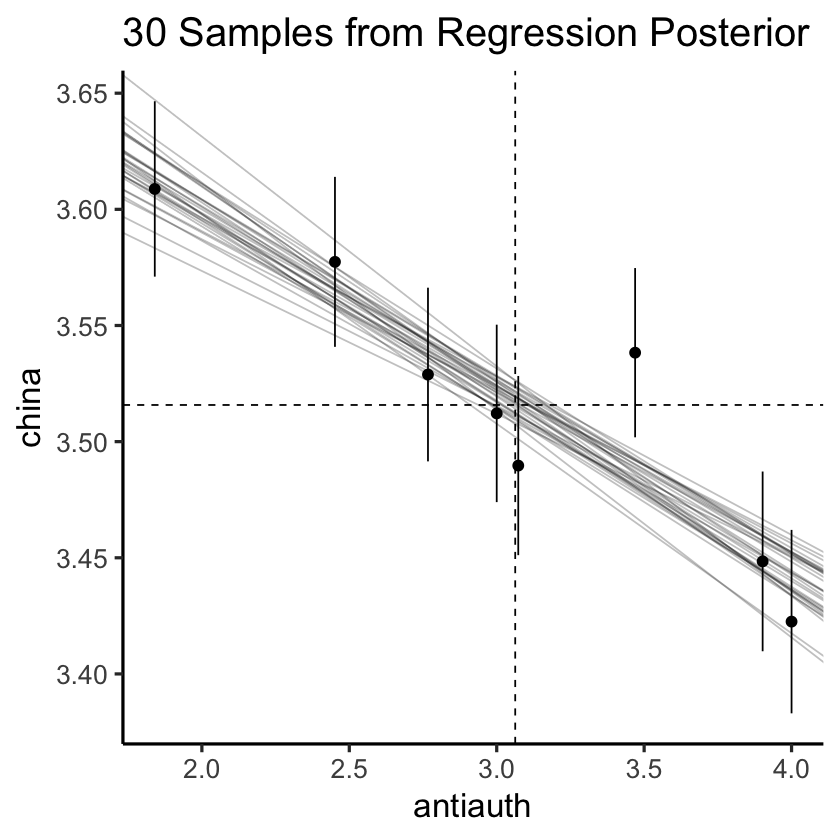

In [ ]:
# @title Q2.1b-response

# Your code here
antiauth_mean <- mean(valid_df$antiauth)
indiv_model <- quap(
  alist(
    china ~ dnorm(mu_china, sigma_china),
    mu_china <- china_at_antiauthmean + slope * (antiauth - antiauth_mean),
    china_at_antiauthmean ~ dnorm(3.06, 1),
    slope ~ dnorm(0,1),
    sigma_china ~ dunif(0,25)
  ),
  data=valid_df
)
(indiv_precis <- precis(indiv_model))

# extract 30 samples(post_df) by drawing variables in indiv_model
set.seed(1296)
num_post_samples <- 30
post_df <- extract.samples(indiv_model, n = num_post_samples) |>
  mutate(intercept=china_at_antiauthmean - slope * antiauth_mean)

ggplot() +
  geom_vline(xintercept=mean(valid_df$antiauth), linetype="dashed") +
  geom_hline(yintercept=mean(valid_df$china), linetype="dashed") +
  geom_abline(
      data=post_df, aes(slope=slope, intercept=intercept),
      alpha = 0.25
  )  +
  stat_binscatter(
      data=valid_df,
      aes(x=antiauth, y=china),
      geom="pointrange", bins=8
  ) +
  theme_classic(base_size=20) +
  labs(title=paste0(num_post_samples, " Samples from Regression Posterior"))


### [Question 2.2] Party-Level Regression

Our model in this question assumes that info about the **political party** an individual voted for is sufficient for determining their sentiment towards China's role in their country.

As in the previous question, the **dependent** variable is `china`. However, here the **independent** variable is a measure of the party's ideology on a left-right spectrum. The following code cell

1.  Drops observations with `NA` values for `ideology_pos_str` (which in fact also drops lots of countries, since this value is `NA` for e.g. monarchies like Eswatini or Morocco), then
2.  Displays counts representing, for each possible ideological position listed on Wikipedia, how many respondents voted for political parties with that position

In [43]:
# @title Q2.2-helper-1
valid_ideology_df <- valid_df |> filter(!is.na(ideology_pos_str))
valid_ideology_df |> count(ideology_pos_str)

ideology_pos_str,n
<chr>,<int>
Center,2070
Center to Center-Left,274
Center to Center-Right,731
Center-Left,5611
Center-Left to Left,1038
Center-Right,2954
Center-Right to Right,928
Left,1279
Right,1604


To really drive the point home that these are... subjective judgements arbitrarily mapped into $[-2,2]$ to make these qualitative judgements quantitatively tractable, the following code cell uses an `ideology_map` tibble with a `left_join()` to add a new `ideology_num` column to `valid_ideology_df`, so that we can then use this column as our **independent variable** to predict `china`:

In [41]:
# @title Q2.2-helper-2
ideology_map <- tribble(
    ~ideology_pos_str, ~ideology_num,
    "Left", -2.0,
    "Center-Left to Left", -1.5,
    "Center-Left", -1.0,
    "Center to Center-Left", -0.5,
    "Center", 0.0,
    "Center to Center-Right", 0.5,
    "Center-Right", 1.0,
    "Center-Right to Right", 1.5,
    "Right", 2.0,
)
ideology_map

ideology_pos_str,ideology_num
<chr>,<dbl>
Left,-2.0
Center-Left to Left,-1.5
Center-Left,-1.0
Center to Center-Left,-0.5
Center,0.0
Center to Center-Right,0.5
Center-Right,1.0
Center-Right to Right,1.5
Right,2.0


As a final piece of starter code, the following code cell performs the `lm()`-based regression of `china` on `ideology_num`, deriving and then plotting an estimate of how sentiment towards China increases or decreases on average as the party one votes for moves from left to right (relative to this arbitrarily-chosen $[-2,2]$ spectrum):

In [50]:
head(ideology_num_df)

id,country_name,china,usa,accountable,gov_is_employee,follow_own_ideas,party_close,party_vote,valid_china,⋯,trade_china,trade_usa,party_name,party_abbr,url,ideology_full_str,ideology_str,ideology_pos_str,valid_party,ideology_num
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
ANG0006,Angola,2,4,3,4,2,9997,1751,TRUE,⋯,20.88941,2.59486,UNITA - Adalberto da Costa Junior,UNITA,https://en.wikipedia.org/wiki/UNITA,Big tent;Conservatism;Anti-communism,Conservatism,Center-Right to Right,TRUE,1.5
ANG0007,Angola,4,4,1,3,4,9997,1751,TRUE,⋯,20.88941,2.59486,UNITA - Adalberto da Costa Junior,UNITA,https://en.wikipedia.org/wiki/UNITA,Big tent;Conservatism;Anti-communism,Conservatism,Center-Right to Right,TRUE,1.5
ANG0008,Angola,5,5,2,4,1,9997,1750,TRUE,⋯,20.88941,2.59486,MPLA/ João Lourenço,MPLA,https://en.wikipedia.org/wiki/MPLA,Angolan nationalism;Social democracy;Democratic socialism,Democratic socialism,Center-Left to Left,TRUE,-1.5
ANG0009,Angola,1,2,3,2,2,1750,1750,TRUE,⋯,20.88941,2.59486,MPLA/ João Lourenço,MPLA,https://en.wikipedia.org/wiki/MPLA,Angolan nationalism;Social democracy;Democratic socialism,Democratic socialism,Center-Left to Left,TRUE,-1.5
ANG0019,Angola,3,3,2,4,4,1751,1751,TRUE,⋯,20.88941,2.59486,UNITA - Adalberto da Costa Junior,UNITA,https://en.wikipedia.org/wiki/UNITA,Big tent;Conservatism;Anti-communism,Conservatism,Center-Right to Right,TRUE,1.5
ANG0026,Angola,2,3,1,4,1,9997,1751,TRUE,⋯,20.88941,2.59486,UNITA - Adalberto da Costa Junior,UNITA,https://en.wikipedia.org/wiki/UNITA,Big tent;Conservatism;Anti-communism,Conservatism,Center-Right to Right,TRUE,1.5


In [47]:
# @title Q2.2-helper-3
ideology_num_df <- valid_ideology_df |>
  filter(valid_party) |>
  left_join(ideology_map, by="ideology_pos_str")

# Estimate and display the regression coefficients
ideology_lm <- lm(china ~ ideology_num, data=ideology_num_df)
summary(ideology_lm)

# Plot the estimated line on top of a binscatter of ideological spectrum values
ggplot() +
    geom_hline(yintercept=mean(ideology_num_df$china), linetype="dashed") +
    geom_vline(xintercept=mean(ideology_num_df$ideology_num), linetype="dashed") +
    geom_smooth(
        data=ideology_num_df, aes(x=ideology_num, y=china),
        method="lm", formula="y ~ x"
    ) +
    stat_binscatter(
      data=ideology_num_df, aes(x=ideology_num, y=china),
      geom="pointrange", bins=20
    ) +
    theme_classic(base_size=18)


Call:
lm(formula = china ~ ideology_num, data = ideology_num_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6274 -1.4820  0.4142  1.4142  1.5387 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.54432    0.01082 327.490  < 2e-16 ***
ideology_num -0.04152    0.00883  -4.703 2.59e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.383 on 16487 degrees of freedom
Multiple R-squared:  0.00134,	Adjusted R-squared:  0.001279 
F-statistic: 22.11 on 1 and 16487 DF,  p-value: 2.589e-06


ERROR: Error in stat_binscatter(data = ideology_num_df, aes(x = ideology_num, : could not find function "stat_binscatter"


As in the previous question, your job in the cell titled `Q2.2a-response` is to **convert** this `lm()`-based regression into a Stan model which recovers the same (approximate) slope and intercept estimates. This time, the code cell is blank besides the `# Your code here` line, but you should name your estimated model (the result of the call to `quap()`) `ideology_model`!

In [ ]:
# @title Q2.2a-response

# Your code here
ideology_num_mean <- mean(ideology_num_df$ideology_num)
ideology_model <- quap(
    alist(
        china ~ dnorm(mu_china, sigma_china),
        mu_china <- china_at_ideology_num_mean + slope * (ideology_num - ideology_num_mean),
        china_at_ideology_num_mean ~ dnorm(3.5, 1),
        slope ~ dnorm(0, 0.5), 
        sigma_china ~ dunif(0, 25)
    ),
    data = ideology_num_df
)
ideology_precis <-precis(ideology_model)
ideology_precis

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
chian_at_ideology_num_mean,3.54920886,0.010771259,3.53199431,3.56642342
slope,-0.04151069,0.008827956,-0.05561946,-0.02740191
sigma_china,1.38321221,0.007616856,1.37103900,1.39538542


And now, sample **30 draws** from the posterior distribution of regression lines in `ideology_model`, using `extract.samples()`, then plot these draws with the same provisions as given above for `Q2.1b-response`:

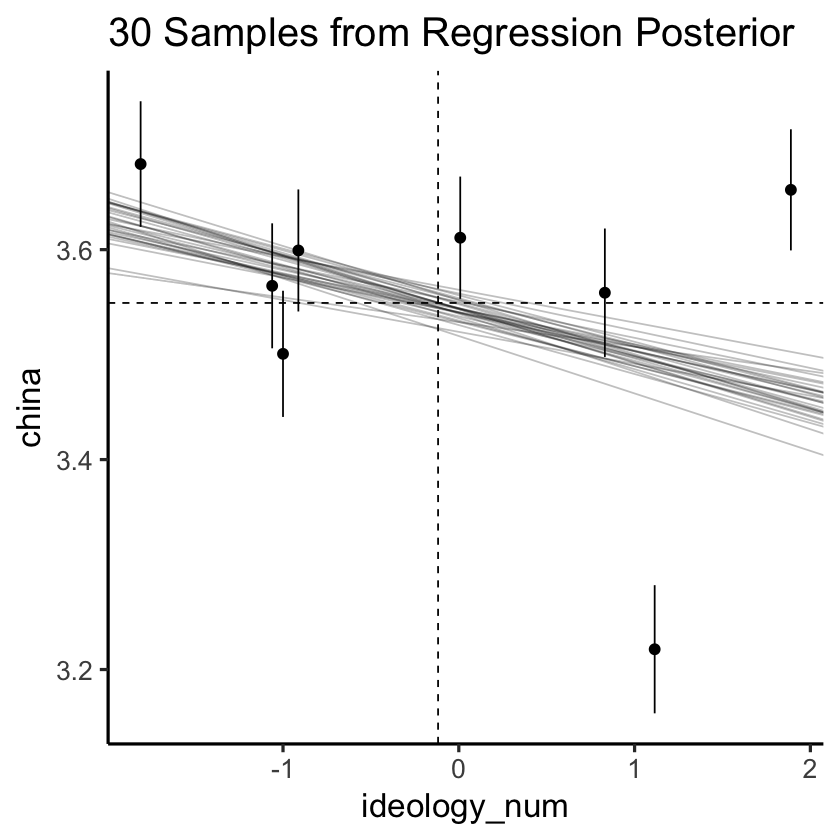

In [ ]:
# @title Q2.2b-response

# Your code here
set.seed(1296)
num_post_samples <- 30
ideology_post_df <- extract.samples(ideology_model, n = num_post_samples) |>
    mutate(intercept = china_at_ideology_num_mean - slope * ideology_num_mean)

ggplot() +
  geom_vline(xintercept=mean(ideology_num_df$ideology_num), linetype="dashed") +
  geom_hline(yintercept=mean(ideology_num_df$china), linetype="dashed") +
  geom_abline(
      data=ideology_post_df, aes(slope=slope, intercept=intercept),
      alpha = 0.25
  )  +
  stat_binscatter(
      data=ideology_num_df,
      aes(x=ideology_num, y=china),
      geom="pointrange", bins=8
  ) +
  theme_classic(base_size=20) +
  labs(title=paste0(num_post_samples, " Samples from Regression Posterior"))


### [Question 2.3] Country-Level Regression

Since we have bilateral trade data for every country in the Afrobarometer sample with China, we don't need to worry about dropping `NA` values in this case. So, your job in this question is to "convert" one final `lm()`-based regression into a model written in Stan. Here, the dependent variable will be `china` as before, but the **independent** variable is now `ltrade_china`, the **natural log** of the total volume of trade between the respondent's country and China (we take the log because, as you may have seen in econ classes/examples, economic variables like income and trade are often skewed such that values become more evenly-spaced after applying the log transformation). As before, run the following starter code to see the `lm()`-based estimate, then convert the `lm()`-based model into a Stan model in `Q2.3a-response` and `Q2.3b-response` cells.


Call:
lm(formula = china ~ ltrade_china, data = valid_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9560 -1.3758  0.4514  1.1997  1.7630 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.600766   0.007802  461.54   <2e-16 ***
ltrade_china -0.091874   0.004133  -22.23   <2e-16 ***
---
Signif. codes:  0 *** 0.001 ** 0.01 * 0.05 . 0.1   1

Residual standard error: 1.367 on 40426 degrees of freedom
Multiple R-squared:  0.01208,	Adjusted R-squared:  0.01205 
F-statistic: 494.1 on 1 and 40426 DF,  p-value: < 2.2e-16


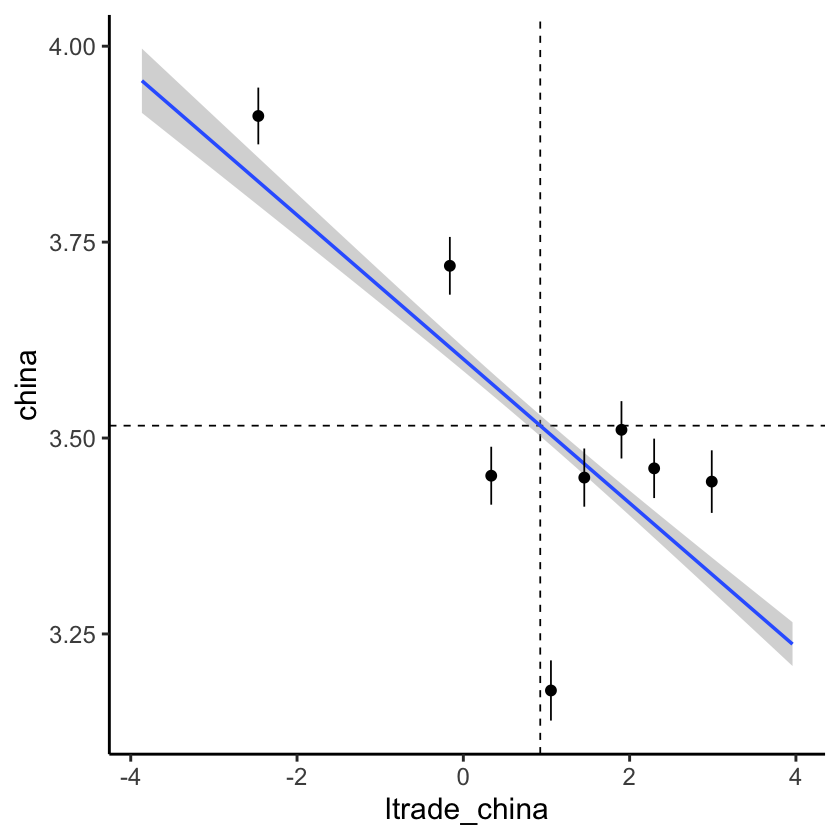

In [ ]:
# @title Q2.3-helper-1
valid_df <- valid_df |> mutate(
    ltrade_china = log(trade_china)
)

# Estimate and display the regression coefficients
trade_lm <- lm(china ~ ltrade_china, data=valid_df)
summary(trade_lm)

# Plot the estimated line on top of a binscatter of log-trade values
ggplot() +
    geom_hline(yintercept=mean(valid_df$china), linetype="dashed") +
    geom_vline(xintercept=mean(valid_df$ltrade_china), linetype="dashed") +
    geom_smooth(
        data=valid_df, aes(x=ltrade_china, y=china),
        method="lm", formula="y ~ x"
    ) +
    stat_binscatter(
      data=valid_df, aes(x=ltrade_china, y=china),
      geom="pointrange", bins=8
    ) +
    theme_classic(base_size=18)

Now, with even fewer instructions than before, fill in the `Q2.3a-response` and `Q2.3b-response` cells as you did in the previous two parts, to obtain and plot a model of China sentiment vs. trade based on the Afrobarometer sample!

In [ ]:
# @title Q2.3a-response

# Your code here (estimate a model named trade_model via a call to quap())
ltrade_china_mean <- mean(valid_df$ltrade_china)
trade_model <- quap(
    alist(
        china ~ dnorm(mu_china, sigma_china),
        mu_china <- china_at_ltrade_mean + slope * (ltrade_china - ltrade_china_mean),
        china_at_ltrade_mean ~ dnorm(3.5, 1),
        slope ~ dnorm(0, 0.5), 
        sigma_china ~ dunif(0, 25)
    ),
    data = valid_df
)
ltrade_precis <- precis(trade_model)
ltrade_precis

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
china_at_ltrade_mean,3.51577986,0.006800355,3.50491158,3.52664814
slope,-0.09186805,0.004132880,-0.09847319,-0.08526291
sigma_china,1.36735982,0.004808681,1.35967462,1.37504502


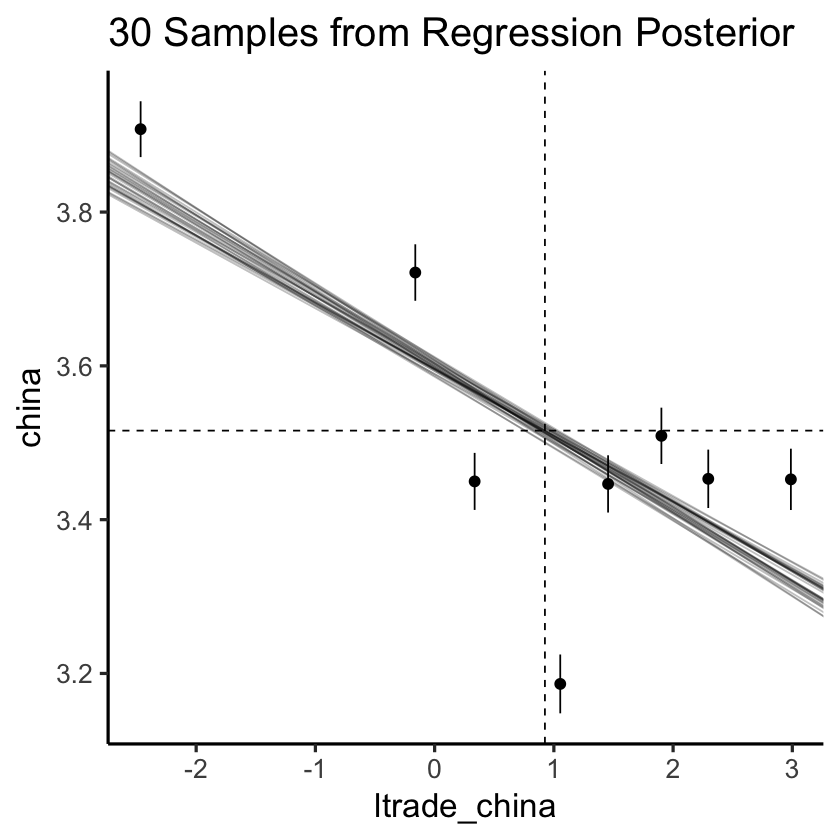

In [ ]:
# @title Q1.3b-response

# Your code here
# (Plot 30 draws from the posterior of trade_model superimposed on a binscatter
# of ltrade_china values, as you did in Q1.1b-response and Q1.2b-response)

set.seed(1296)
num_post_samples <- 30
ltrade_china_post_df <- extract.samples(trade_model, n = num_post_samples) |>
    mutate(intercept = china_at_ltrade_mean - slope * ltrade_china_mean)

ggplot() +
  geom_vline(xintercept=mean(valid_df$ltrade_china), linetype="dashed") +
  geom_hline(yintercept=mean(valid_df$china), linetype="dashed") +
  geom_abline(
      data=ltrade_china_post_df, aes(slope=slope, intercept=intercept),
      alpha = 0.25
  )  +
  stat_binscatter(
      data=valid_df,
      aes(x=ltrade_china, y=china),
      geom="pointrange", bins=8
  ) +
  theme_classic(base_size=20) +
  labs(title=paste0(num_post_samples, " Samples from Regression Posterior"))


Congratulations, you've reached the end of **HW2A**! You can submit this portion of HW2 using the button at the top of the notebook to receive your autograder feedback, and/or move on to **HW2B** 